In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from IPython.display import display
from torchvision import transforms
from torchvision.transforms.functional import to_pil_image

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Load image

In [2]:
def viz_image(torch_img):
    img = to_pil_image(torch_img)
    display(img)

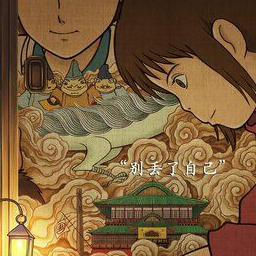

In [3]:
# Read image
img_path = 'data/spirit.jpg'
img = np.array(Image.open(img_path)) # [H,W,C]
offset_x = 100
offset_y = 300
img = img[offset_y:offset_y+256,offset_x:offset_x+256,:]
img = torch.from_numpy(img).to(torch.float32).permute(2,0,1) # [C,H,W]
nimg = img/255 # normalized image

viz_image(nimg)

## MLP

In [4]:
class MLP(nn.Module):
    def __init__(self, in_c=2, out_c=3, hdim=256):
        super(MLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Conv2d(in_c, hdim, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(hdim),
            nn.Conv2d(hdim, hdim, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(hdim),
            nn.Conv2d(hdim, hdim, kernel_size=1),
            nn.ReLU(),
            nn.BatchNorm2d(hdim),
            nn.Conv2d(hdim, out_c, kernel_size=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        x: [B, C, H, W]
        """
        return self.mlp(x)

In [5]:
# Prepare training data
_,H,W = nimg.shape
yy,xx = torch.meshgrid(torch.linspace(0,1,H), torch.linspace(0,1,W), indexing='ij')
grid = torch.stack([xx,yy], dim=0).unsqueeze(0) # [1,2,H,W]
target = nimg.unsqueeze(0) # [1,2,H,W]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [6]:
def train_model(model, grid, target):
    # training
    print('Using device:', device)
    grid = grid.to(device)
    target = target.to(device)

    model = model.to(device)
    opt = optim.Adam(model.parameters(), lr=1e-4)
    loss_fn = nn.MSELoss()
    num_steps = 500

    caches = {'loss': [], 'img': []}
    for step in tqdm(range(num_steps), desc="Training"):
        pred = model(grid)
        loss = loss_fn(pred, target)
        opt.zero_grad()
        loss.backward()
        opt.step()

        if step % 100 == 0 or step == num_steps - 1:
            _loss = loss.item()
            caches['loss'].append(_loss)
            caches['img'].append(pred.detach().cpu())
            print(f'Step {step}: loss = {_loss:.2e}')
    return caches

In [7]:
model_base = MLP(2)
caches = train_model(model_base, grid, target)

Using device: cuda


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Step 0: loss = 7.66e-02
Step 100: loss = 2.82e-02
Step 200: loss = 2.06e-02
Step 300: loss = 1.78e-02
Step 400: loss = 1.61e-02
Step 499: loss = 1.46e-02


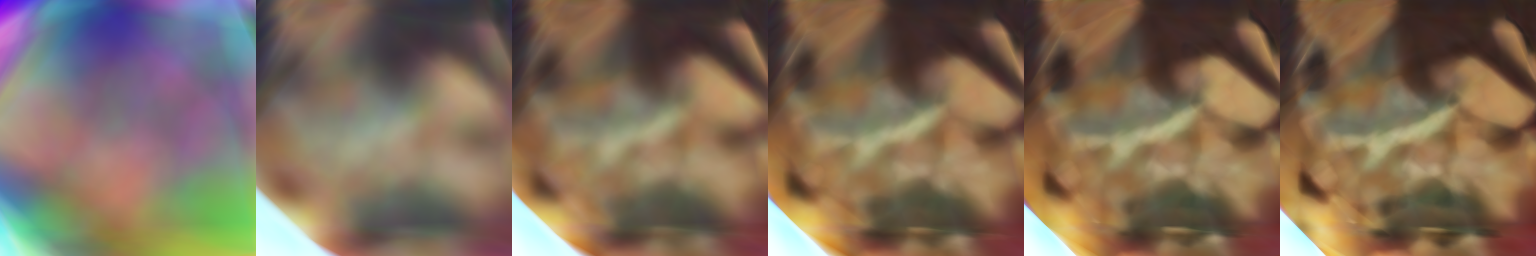

In [8]:
# Plot cached images
viz_image(torch.cat(caches['img'], dim=-1)[0])

## Fourier features

In [9]:
class RandomFourierFeatures(nn.Module):
    def __init__(self, in_c, out_c, std=16.0):
        super().__init__()
        self.freqs = torch.randn(in_c, out_c//2) * std
        self.register_buffer('rrf_freqs', self.freqs)
    
    def forward(self, x):
        """
        x: [B, C, H, W]
        """
        x = x.permute(0, 2, 3, 1) # [B, H, W, C]
        x = x @ self.freqs # [B, H, W, out_c//2]
        x = torch.pi * x
        x = torch.cat([torch.cos(x), torch.sin(x)], dim=-1)
        x = x.permute(0, 3, 1, 2)
        return x # [B, out_c, H, W]

In [10]:
feat_emb = RandomFourierFeatures(2, 256, std=2**4).to(device)
grid_emb = feat_emb(grid)
model = MLP(256).to(device)
caches = train_model(model, grid_emb, target)

Using device: cuda


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Step 0: loss = 7.96e-02
Step 100: loss = 2.96e-02
Step 200: loss = 1.37e-02
Step 300: loss = 7.51e-03
Step 400: loss = 5.67e-03
Step 499: loss = 4.56e-03


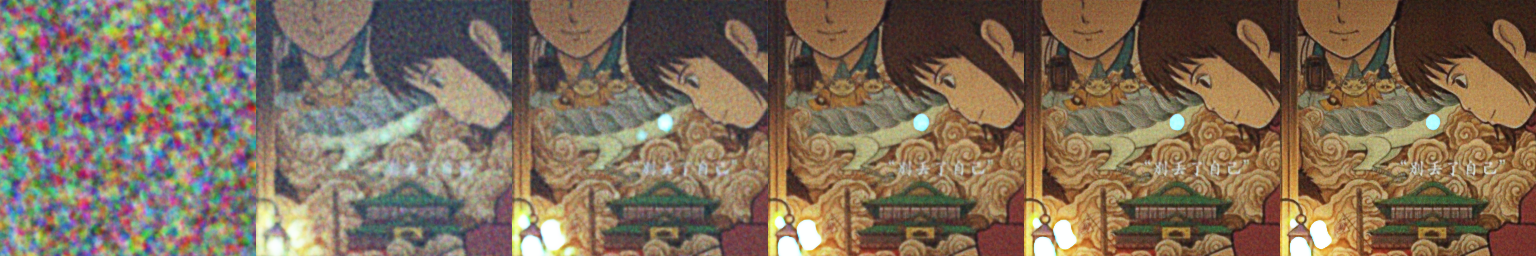

In [11]:
# Plot cached images
viz_image(torch.cat(caches['img'], dim=-1)[0])

In [12]:
class RandomCosineFeatures(nn.Module):
    def __init__(self, in_c, out_c, std=16.0):
        super().__init__()
        self.freqs = torch.randn(in_c, out_c) * std
        self.register_buffer('rcf_freqs', self.freqs)
    
    def forward(self, x):
        """
        x: [B, C, H, W]
        """
        x = x.permute(0, 2, 3, 1)
        x = x @ self.freqs
        x = torch.pi * x
        x = torch.cos(x)
        x = x.permute(0, 3, 1, 2)
        return x

class RandomAffine(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        """
        x: [B, 2, H, W]
        """
        B,C,H,W = x.shape
        assert C == 2, "Input channel must be 2"
        x = x.permute(0, 2, 3, 1)
        trans = (2 * torch.rand(B, 2) - 1) / 2
        thetas = (2 * torch.rand(B) - 1) * torch.pi / 10
        offset = torch.tensor([1/2, 1/2])

        Ts = torch.zeros(B, 2, 3)
        Ts[:, 0, 0] = torch.cos(thetas)
        Ts[:, 0, 1] = -torch.sin(thetas)
        Ts[:, 0, 2] = trans[:, 0]
        Ts[:, 1, 0] = torch.sin(thetas)
        Ts[:, 1, 1] = torch.cos(thetas)
        Ts[:, 1, 2] = trans[:, 1]
        Ts = Ts.to(x.device) # [B, 2, 3]
        
        _x = torch.ones(B, H, W, 3).to(x.device)
        _x[..., :2] = x - offset # shift to the center
        _x = torch.einsum('bij,bhwj->bhwi', Ts, _x) # [B, H, W, 2]
        _x = _x + offset # shift back
        _x = _x.permute(0, 3, 1, 2) # [B, 2, H, W]
        return _x
        

In [13]:
feat_emb = RandomCosineFeatures(2, 256, std=2**4).to(device)
grid_emb = feat_emb(grid)
model = MLP(256).to(device)
caches = train_model(model, grid_emb, target)

Using device: cuda


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Step 0: loss = 8.34e-02
Step 100: loss = 3.25e-02
Step 200: loss = 1.33e-02
Step 300: loss = 8.44e-03
Step 400: loss = 6.74e-03
Step 499: loss = 5.58e-03


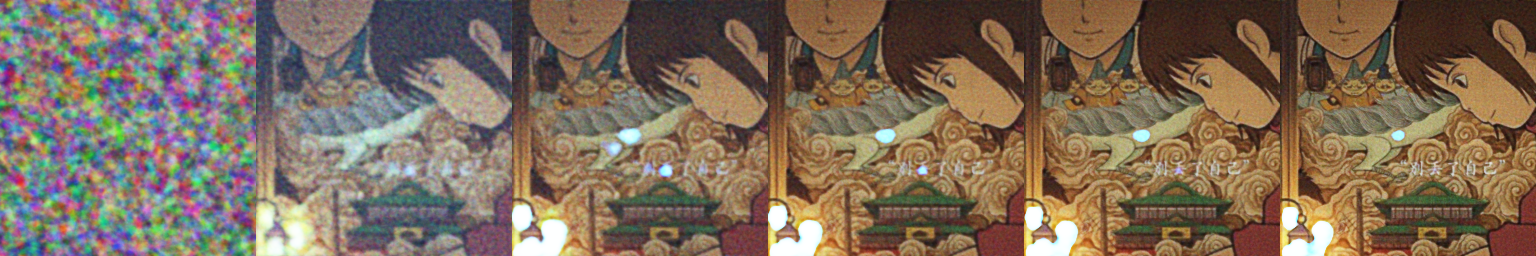

In [14]:
# Plot cached images
viz_image(torch.cat(caches['img'], dim=-1)[0])

## Covariance

做了傅里叶位置编码后, MLP对输入具备平移不变性(准确来说应该是*协变* equivariant). 我们对输入坐标做随机的仿射变换后, 输出也跟着变. 有意思的是, 有些时候输出图像在边缘处呈现周期性, 这是因为我们自己实现的 `RandomAffine` 对变换后图像以外的部分不做 zero/fill padding, 这和 `torchvision.transfom.functional.affine` 的实现不同. 加上傅里叶编码是周期函数, 所以模型输出可能会出现类似 checkerborad 的现象.

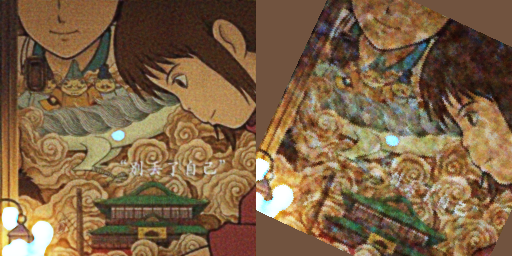

In [15]:
grid_aff = RandomAffine()(grid)
grid_aff = transforms.functional.affine(grid, angle=25, translate=[20,10], scale=1, shear=0)
grid_aff_emb = feat_emb(grid_aff).to(device)
pred_aff = model(grid_aff_emb).detach().cpu()

grid_emb = feat_emb(grid).to(device)
pred = model(grid_emb).detach().cpu()

viz_image(torch.cat([pred, pred_aff], dim=-1)[0])

可以看到, 做了傅里叶编码后, 模型的输入实际上就是一组2D傅里叶变换基函数. 而MLP第一层网络学习的是傅里叶变换的系数.

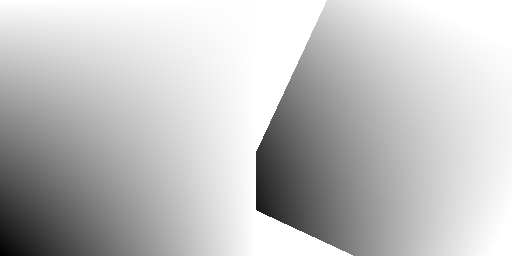

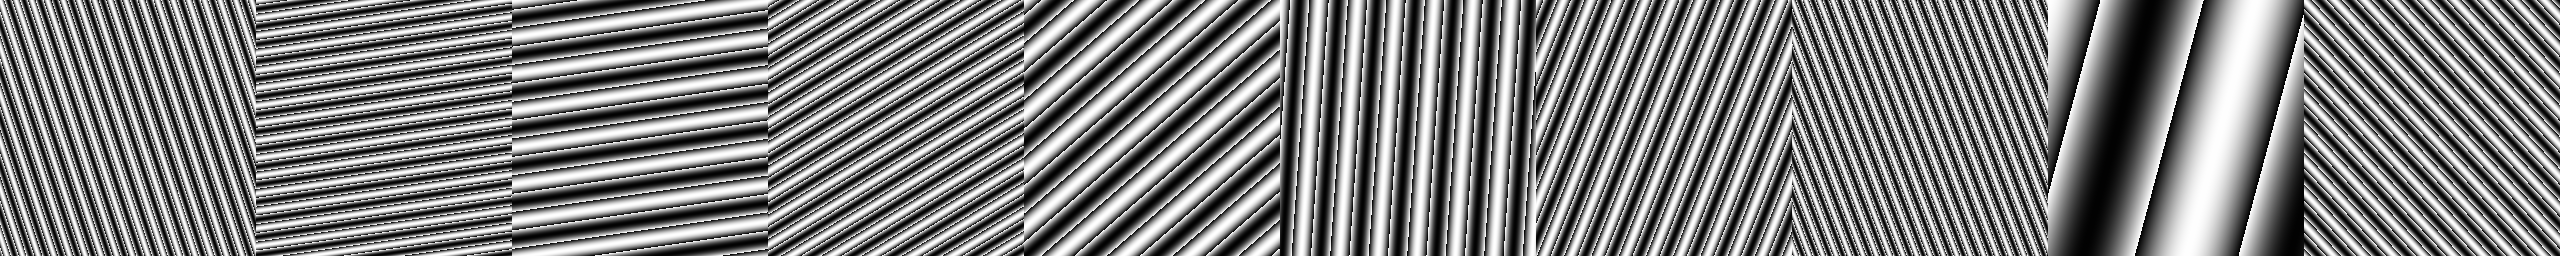

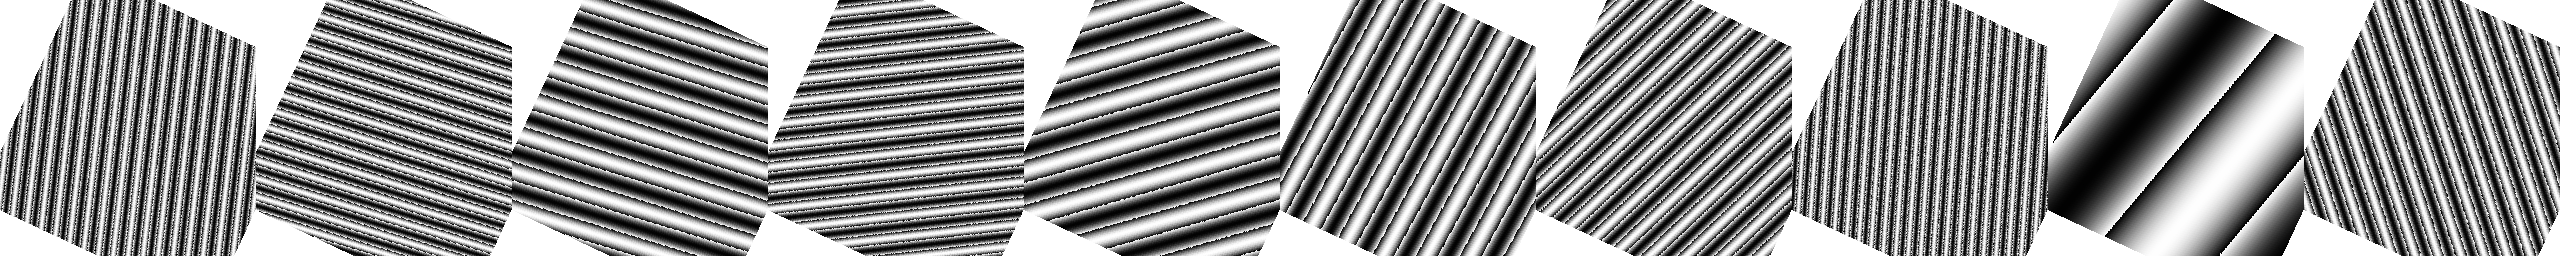

In [16]:
viz_image(torch.cat([grid[0], grid_aff[0]], dim=-1)),
viz_image(torch.cat([*grid_emb[0][:10]], dim=-1))
viz_image(torch.cat([*grid_aff_emb[0][:10]], dim=-1))

单纯的 MLP+ReLU 其实是具备对输入的协变性的, 因为对每个 grid point 的操作是独立的. 但是这里实现里还用了 BatchNorm 操作, 导致空间上有耦合, 提升了训练效果, 但削弱了协变性 (可以注释掉 BatchNorm 试试看).

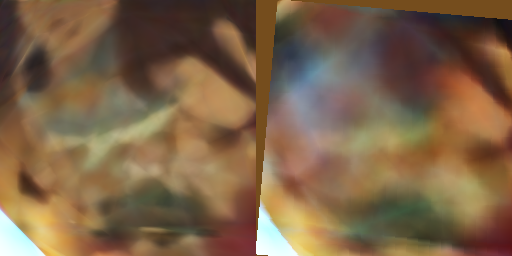

In [24]:
# grid_aff = RandomAffine()(grid).to(device)
grid_aff = transforms.functional.affine(grid, angle=5, translate=[10,10], scale=1, shear=0).to(device)
pred_aff = model_base(grid_aff).detach().cpu()
pred = model_base(grid.to(device)).detach().cpu()

viz_image(torch.cat([pred, pred_aff], dim=-1)[0])

In [18]:
class CNN(nn.Module):
    def __init__(self, in_c=2, out_c=3, hdim=256):
        super(CNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(in_c, hdim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hdim),
            nn.Conv2d(hdim, hdim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hdim),
            nn.Conv2d(hdim, hdim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hdim),
            nn.Conv2d(hdim, out_c, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        x: [B, C, H, W]
        """
        return self.cnn(x)

In [19]:
model_cnn = CNN(2)
caches = train_model(model_cnn, grid, target)

Using device: cuda


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Step 0: loss = 8.36e-02
Step 100: loss = 1.82e-02
Step 200: loss = 1.75e-02
Step 300: loss = 1.42e-02
Step 400: loss = 1.35e-02
Step 499: loss = 1.31e-02


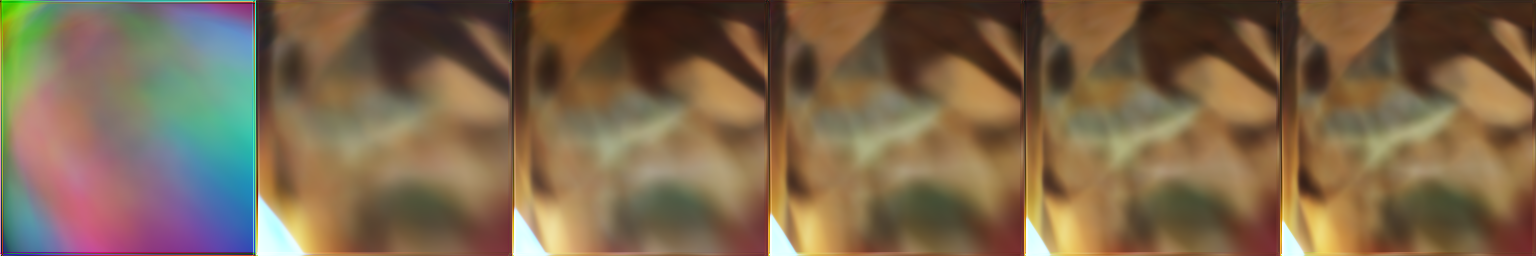

In [20]:
# Plot cached images
viz_image(torch.cat(caches['img'], dim=-1)[0])

把 MLP 里的 Conv2d 的 `kernel_size` 调大并添加 `padding`, 就得到了 CNN. 在不施加傅里叶位置编码的情况下, CNN 优于 MLP, 且在小变换下更具鲁棒性, 模型输出的图像还是能看得出原图的样子. 但在大变换下效果不佳. 上面也分析过, 其实 MLP (不加 BatchNorm) 本来就是输入协变的, 而 CNN 因为卷积的操作, 也是具备输入协变性的.

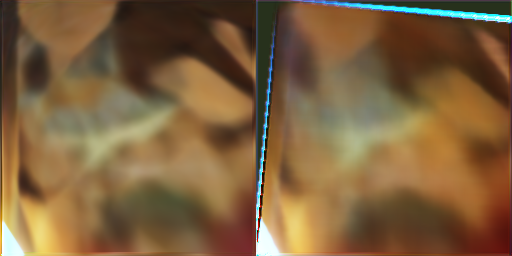

In [25]:
grid_aff = transforms.functional.affine(grid, angle=5, translate=[10,10], scale=1, shear=0).to(device)
pred_aff = model_cnn(grid_aff).detach().cpu()
pred = model_cnn(grid.to(device)).detach().cpu()

viz_image(torch.cat([pred, pred_aff], dim=-1)[0])